# **Báo cáo bài tập lớn môn Học máy**

- Mã lớp: INT3405_1
- Giảng viên: Trần Quốc Long
- Họ tên sinh viên: Đặng Minh Hoàng
- Mã sinh viên: 18020541

#    **1. Mô tả vấn đề bài toán**

***Quora*** là một nền tảng cho phép mọi người học hỏi lẫn nhau. Trên ***Quora***, mọi người có thể đặt câu hỏi và kết nối với những người khác, những người đóng góp cái nhìn chi tiết độc đáo và câu trả lời chất lượng. Một thách thức quan trọng là loại bỏ những câu hỏi thiếu chân thành - những câu hỏi được đặt ra dựa trên những tiền đề sai lầm hoặc có ý định đưa ra một tuyên bố hơn là tìm kiếm những câu trả lời hữu ích.

### **Nhiệm vụ bài toán:**

- Trong bài toán này, ta cần phân loại các câu hỏi (Question Classification) xem chúng có phải câu toxic question (những câu hỏi có hàm ý xấu, dễ gây hiểu lầm) không.
- Đây là một bài toán dạng Binary Classifier với 2 lớp là insincere (1) và sincere (0)
- Đầu vàobài toán: Dữ liệu câu hỏi trên Quora dưới dạng văn bản
- Đầu ra: [ “yes” : 1, “no” : 0 ]

#   **2. Phân tích dữ liệu, convert, clean dữ liệu**
Thêm một số thư viện


In [ ]:
import pandas as pd 
import numpy as np 
%matplotlib inline
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
import operator
import gc
import matplotlib as mp 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import re

# a. Phân tích dữ liệu

**Đọc dữ liệu**

In [ ]:
data_raw = pd.read_csv('../input/quora-insincere-questions-classification/train.csv')
data_raw.head()

In [ ]:
test_data=pd.read_csv("../input/quora-insincere-questions-classification/test.csv")

In [ ]:
data_raw.info()

**Bộ dữ liệu train.csv có:**
- Số dòng: ~1.3 triệu dòng
- Số cột: 3 cột

**Dạng data field**
- qid: mã câu hỏi
- question_text: nội dung câu hỏi (nội dung cần phân loại)
- target: nhãn (insincere - 1, sincere - 0)

In [ ]:
data_raw.target.value_counts()

In [ ]:
sns.countplot(data=data_raw, x='target')

**Đánh giá bộ dữ liệu:**
Ta có thể thấy độ phân bố của 2 class 0 và 1 như sau:
- class 0 chiếm 1225312 tương ứng với ~93.8%
- class 1 chiếm 80810 tương ứng với ~6,19%

Bộ dữ liệu không cân bằng, ảnh hưởng đến chất lượng đánh giá của mô hình

Để đánh giá mô hình mất cân bằng mẫu cao như vậy, ta có thể sử dụng f1_score để làm chỉ số đánh giá thay thế:
- Ta có thể biểu diễn f1_score bằng biểu thức như sau: 

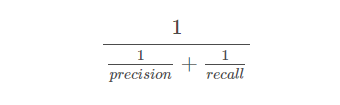
    
- Với
    - Precision là mức độ dự báo chính xác trong những trường hợp được dự báo là Positive
    - Recall là mức độ dữ báo chuẩn xác trong những trường hợp là Positive với thực tế cũng là Positive 
    
    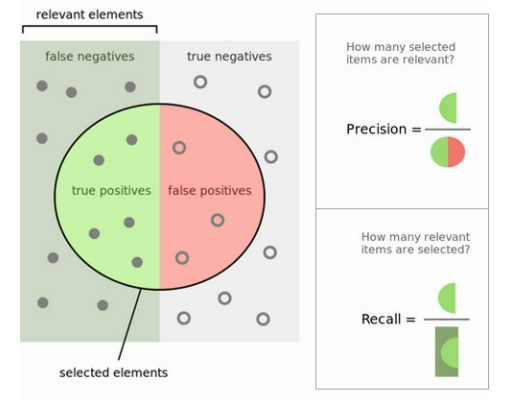

In [ ]:
data_raw.target.value_counts(normalize=True)


In [ ]:
insincere_questions = data_raw[data_raw['target'] == 1].question_text
sincere_questions = data_raw[data_raw['target'] == 0].question_text

In [ ]:
insincere_questions.sample(n=3, random_state=0).values


In [ ]:
train,val=train_test_split(data_raw,test_size=0.004,stratify=data_raw.target,random_state=123)
print("Shape of the Training set :",train.shape)
print("Shape of the Validation set :",val.shape)

**Phân tích các từ xuất hiện nhiều nhất bằng n-gram**: là tần suất xuất hiện của n kí tự ( hoặc từ ) liên tiếp nhau có trong dữ liệu của corpus.

- unigram, mô hình với n=1, tức là ta sẽ tính tần suất xuất hiện của một kí tự (từ), như: “k”, “a”,…
- bigrams với n=2, mô hình được sử dụng nhiều trong việc phân tích các hình thái cho ngôn ngữ, ví dụ với các chữ cái tiếng Anh, ‘th’,’he’,’in’,’an’,’er’ là các cặp kí tự hay xuất hiện nhất.
- trigrams với n=3.

In [ ]:
from wordcloud import STOPWORDS
from collections import defaultdict
import seaborn as sns
import nltk

def ngram_extractor(text, n_gram):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

# Lấy max_row các từ dạng n_gram xuất hiện nhiều nhất trong dữ liệu
def generate_ngrams(df, col, n_gram, max_row):
    temp_dict = defaultdict(int)
    for question in df[col]:
        for word in ngram_extractor(question, n_gram):
            temp_dict[word] += 1
    temp_df = pd.DataFrame(sorted(temp_dict.items(), key=lambda x: x[1])[::-1]).head(max_row)
    temp_df.columns = ["word", "wordcount"]
    return temp_df

def comparison_plot(df_1,df_2,col_1,col_2):
    fig, ax = plt.subplots(1, 2, figsize=(20,10))
    
    sns.barplot(x=col_2, y=col_1, data=df_1, ax=ax[0])
    sns.barplot(x=col_2, y=col_1, data=df_2, ax=ax[1])

    ax[0].set_xlabel('Word count', size=12)
    ax[0].set_ylabel('Words', size=12)
    ax[0].set_title('Top words in sincere questions', size=16)

    ax[1].set_xlabel('Word count', size=12)
    ax[1].set_ylabel('Words', size=12)
    ax[1].set_title('Top words in insincere questions', size=16)

    fig.subplots_adjust(wspace=0.25)
    
    plt.show()

In [ ]:
# 20 từ dạng unigram xuất hiện nhiều nhất trong 2 loại tập câu hỏi
sincere_1gram = generate_ngrams(sincere_data, 'question_text', 1, 20)
insincere_1gram = generate_ngrams(insincere_data, 'question_text', 1, 20)

comparison_plot(sincere_1gram,insincere_1gram,'word','wordcount')

In [ ]:
# 20 từ dạng bigram xuất hiện nhiều nhất trong 2 loại tập câu hỏi
sincere_2gram = generate_ngrams(sincere_data, 'question_text', 2, 20)
insincere_2gram = generate_ngrams(insincere_data, 'question_text', 2, 20)

comparison_plot(sincere_1gram,insincere_1gram,'word','wordcount')

In [ ]:
#Lấy ra 20 từ dạng trigram xuất hiện nhiều nhất trong 2 loại tập câu hỏi
sincere_3gram = generate_ngrams(sincere_data, 'question_text', 3, 20)
insincere_3gram = generate_ngrams(insincere_data, 'question_text', 3, 20)

comparison_plot(sincere_1gram,insincere_1gram,'word','wordcount')

# b. Tiền xử lý

**Clean data**

In [ ]:
#Import thư viện xử lý ngôn ngữ
import nltk
import sys
import spacy

# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')

# from nltk.corpus import stopwords
import string

In [ ]:
# nltk_stopword = stopwords.words('english')

**Chuyển các từ viết tắt sang dạng đầy đủ**

In [ ]:
contractions={"I'm": 'I am',
 "I'm'a": 'I am about to',
 "I'm'o": 'I am going to',
 "I've": 'I have',
 "I'll": 'I will',
 "I'll've": 'I will have',
 "I'd": 'I would',
 "I'd've": 'I would have',
 'Whatcha': 'What are you',
 "amn't": 'am not',
 "ain't": 'are not',
 "aren't": 'are not',
 "'cause": 'because',
 "can't": 'can not',
 "can't've": 'can not have',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 "daren't": 'dare not',
 "daresn't": 'dare not',
 "dasn't": 'dare not',
 "didn't": 'did not',
 'didn’t': 'did not',
 "don't": 'do not',
 'don’t': 'do not',
 "doesn't": 'does not',
 "e'er": 'ever',
 "everyone's": 'everyone is',
 'finna': 'fixing to',
 'gimme': 'give me',
 "gon't": 'go not',
 'gonna': 'going to',
 'gotta': 'got to',
 "hadn't": 'had not',
 "hadn't've": 'had not have',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he've": 'he have',
 "he's": 'he is',
 "he'll": 'he will',
 "he'll've": 'he will have',
 "he'd": 'he would',
 "he'd've": 'he would have',
 "here's": 'here is',
 "how're": 'how are',
 "how'd": 'how did',
 "how'd'y": 'how do you',
 "how's": 'how is',
 "how'll": 'how will',
 "isn't": 'is not',
 "it's": 'it is',
 "'tis": 'it is',
 "'twas": 'it was',
 "it'll": 'it will',
 "it'll've": 'it will have',
 "it'd": 'it would',
 "it'd've": 'it would have',
 'kinda': 'kind of',
 "let's": 'let us',
 'luv': 'love',
 "ma'am": 'madam',
 "may've": 'may have',
 "mayn't": 'may not',
 "might've": 'might have',
 "mightn't": 'might not',
 "mightn't've": 'might not have',
 "must've": 'must have',
 "mustn't": 'must not',
 "mustn't've": 'must not have',
 "needn't": 'need not',
 "needn't've": 'need not have',
 "ne'er": 'never',
 "o'": 'of',
 "o'clock": 'of the clock',
 "ol'": 'old',
 "oughtn't": 'ought not',
 "oughtn't've": 'ought not have',
 "o'er": 'over',
 "shan't": 'shall not',
 "sha'n't": 'shall not',
 "shalln't": 'shall not',
 "shan't've": 'shall not have',
 "she's": 'she is',
 "she'll": 'she will',
 "she'd": 'she would',
 "she'd've": 'she would have',
 "should've": 'should have',
 "shouldn't": 'should not',
 "shouldn't've": 'should not have',
 "so've": 'so have',
 "so's": 'so is',
 "somebody's": 'somebody is',
 "someone's": 'someone is',
 "something's": 'something is',
 'sux': 'sucks',
 "that're": 'that are',
 "that's": 'that is',
 "that'll": 'that will',
 "that'd": 'that would',
 "that'd've": 'that would have',
 'em': 'them',
 "there're": 'there are',
 "there's": 'there is',
 "there'll": 'there will',
 "there'd": 'there would',
 "there'd've": 'there would have',
 "these're": 'these are',
 "they're": 'they are',
 "they've": 'they have',
 "they'll": 'they will',
 "they'll've": 'they will have',
 "they'd": 'they would',
 "they'd've": 'they would have',
 "this's": 'this is',
 "those're": 'those are',
 "to've": 'to have',
 'wanna': 'want to',
 "wasn't": 'was not',
 "we're": 'we are',
 "we've": 'we have',
 "we'll": 'we will',
 "we'll've": 'we will have',
 "we'd": 'we would',
 "we'd've": 'we would have',
 "weren't": 'were not',
 "what're": 'what are',
 "what'd": 'what did',
 "what've": 'what have',
 "what's": 'what is',
 "what'll": 'what will',
 "what'll've": 'what will have',
 "when've": 'when have',
 "when's": 'when is',
 "where're": 'where are',
 "where'd": 'where did',
 "where've": 'where have',
 "where's": 'where is',
 "which's": 'which is',
 "who're": 'who are',
 "who've": 'who have',
 "who's": 'who is',
 "who'll": 'who will',
 "who'll've": 'who will have',
 "who'd": 'who would',
 "who'd've": 'who would have',
 "why're": 'why are',
 "why'd": 'why did',
 "why've": 'why have',
 "why's": 'why is',
 "will've": 'will have',
 "won't": 'will not',
 "won't've": 'will not have',
 "would've": 'would have',
 "wouldn't": 'would not',
 "wouldn't've": 'would not have',
 "y'all": 'you all',
 "y'all're": 'you all are',
 "y'all've": 'you all have',
 "y'all'd": 'you all would',
 "y'all'd've": 'you all would have',
 "you're": 'you are',
 "you've": 'you have',
 "you'll've": 'you shall have',
 "you'll": 'you will',
 "you'd": 'you would',
 "you'd've": 'you would have',
 'jan.': 'january',
 'feb.': 'february',
 'mar.': 'march',
 'apr.': 'april',
 'jun.': 'june',
 'jul.': 'july',
 'aug.': 'august',
 'sep.': 'september',
 'oct.': 'october',
 'nov.': 'november',
 'dec.': 'december',
 'I’m': 'I am',
 'I’m’a': 'I am about to',
 'I’m’o': 'I am going to',
 'I’ve': 'I have',
 'I’ll': 'I will',
 'I’ll’ve': 'I will have',
 'I’d': 'I would',
 'I’d’ve': 'I would have',
 'amn’t': 'am not',
 'ain’t': 'are not',
 'aren’t': 'are not',
 '’cause': 'because',
 'can’t': 'can not',
 'can’t’ve': 'can not have',
 'could’ve': 'could have',
 'couldn’t': 'could not',
 'couldn’t’ve': 'could not have',
 'daren’t': 'dare not',
 'daresn’t': 'dare not',
 'dasn’t': 'dare not',
 'doesn’t': 'does not',
 'e’er': 'ever',
 'everyone’s': 'everyone is',
 'gon’t': 'go not',
 'hadn’t': 'had not',
 'hadn’t’ve': 'had not have',
 'hasn’t': 'has not',
 'haven’t': 'have not',
 'he’ve': 'he have',
 'he’s': 'he is',
 'he’ll': 'he will',
 'he’ll’ve': 'he will have',
 'he’d': 'he would',
 'he’d’ve': 'he would have',
 'here’s': 'here is',
 'how’re': 'how are',
 'how’d': 'how did',
 'how’d’y': 'how do you',
 'how’s': 'how is',
 'how’ll': 'how will',
 'isn’t': 'is not',
 'it’s': 'it is',
 '’tis': 'it is',
 '’twas': 'it was',
 'it’ll': 'it will',
 'it’ll’ve': 'it will have',
 'it’d': 'it would',
 'it’d’ve': 'it would have',
 'let’s': 'let us',
 'ma’am': 'madam',
 'may’ve': 'may have',
 'mayn’t': 'may not',
 'might’ve': 'might have',
 'mightn’t': 'might not',
 'mightn’t’ve': 'might not have',
 'must’ve': 'must have',
 'mustn’t': 'must not',
 'mustn’t’ve': 'must not have',
 'needn’t': 'need not',
 'needn’t’ve': 'need not have',
 'ne’er': 'never',
 'o’': 'of',
 'o’clock': 'of the clock',
 'ol’': 'old',
 'oughtn’t': 'ought not',
 'oughtn’t’ve': 'ought not have',
 'o’er': 'over',
 'shan’t': 'shall not',
 'sha’n’t': 'shall not',
 'shalln’t': 'shall not',
 'shan’t’ve': 'shall not have',
 'she’s': 'she is',
 'she’ll': 'she will',
 'she’d': 'she would',
 'she’d’ve': 'she would have',
 'should’ve': 'should have',
 'shouldn’t': 'should not',
 'shouldn’t’ve': 'should not have',
 'so’ve': 'so have',
 'so’s': 'so is',
 'somebody’s': 'somebody is',
 'someone’s': 'someone is',
 'something’s': 'something is',
 'that’re': 'that are',
 'that’s': 'that is',
 'that’ll': 'that will',
 'that’d': 'that would',
 'that’d’ve': 'that would have',
 'there’re': 'there are',
 'there’s': 'there is',
 'there’ll': 'there will',
 'there’d': 'there would',
 'there’d’ve': 'there would have',
 'these’re': 'these are',
 'they’re': 'they are',
 'they’ve': 'they have',
 'they’ll': 'they will',
 'they’ll’ve': 'they will have',
 'they’d': 'they would',
 'they’d’ve': 'they would have',
 'this’s': 'this is',
 'those’re': 'those are',
 'to’ve': 'to have',
 'wasn’t': 'was not',
 'we’re': 'we are',
 'we’ve': 'we have',
 'we’ll': 'we will',
 'we’ll’ve': 'we will have',
 'we’d': 'we would',
 'we’d’ve': 'we would have',
 'weren’t': 'were not',
 'what’re': 'what are',
 'what’d': 'what did',
 'what’ve': 'what have',
 'what’s': 'what is',
 'what’ll': 'what will',
 'what’ll’ve': 'what will have',
 'when’ve': 'when have',
 'when’s': 'when is',
 'where’re': 'where are',
 'where’d': 'where did',
 'where’ve': 'where have',
 'where’s': 'where is',
 'which’s': 'which is',
 'who’re': 'who are',
 'who’ve': 'who have',
 'who’s': 'who is',
 'who’ll': 'who will',
 'who’ll’ve': 'who will have',
 'who’d': 'who would',
 'who’d’ve': 'who would have',
 'why’re': 'why are',
 'why’d': 'why did',
 'why’ve': 'why have',
 'why’s': 'why is',
 'will’ve': 'will have',
 'won’t': 'will not',
 'won’t’ve': 'will not have',
 'would’ve': 'would have',
 'wouldn’t': 'would not',
 'wouldn’t’ve': 'would not have',
 'y’all': 'you all',
 'y’all’re': 'you all are',
 'y’all’ve': 'you all have',
 'y’all’d': 'you all would',
 'y’all’d’ve': 'you all would have',
 'you’re': 'you are',
 'you’ve': 'you have',
 'you’ll’ve': 'you shall have',
 'you’ll': 'you will',
 'you’d': 'you would',
 'you’d’ve': 'you would have'}

def contraction_fix(word):
    try:
        a=contractions[word]
    except KeyError:
        a=word
    return a

In [ ]:
def Preprocess(doc):
    corpus=[]
    for text in tqdm(doc):
        text=" ".join([contraction_fix(w) for w in text.split()])
        text = text.lower()
        text=re.sub(r'[^a-z0-9A-Z]'," ",text)
        text=re.sub(r'[0-9]{1}',"#",text)
        text=re.sub(r'[0-9]{2}','##',text)
        text=re.sub(r'[0-9]{3}','###',text)
        text=re.sub(r'[0-9]{4}','####',text)
        text=re.sub(r'[0-9]{5,}','#####',text)
        corpus.append(text)
    return corpus
def get_vocab(corpus):
    vocab={}
    for text in tqdm(corpus):
        for word in text.split():
            try:
                vocab[word]+=1
            except KeyError:
                vocab[word]=1
    vocab=dict(sorted(vocab.items(),reverse=True ,key=lambda item: item[1]))
    return vocab

Mô hình sẽ học tốt hơn nếu như các từ có trọng số hợp lý, vì vậy ta sẽ dùng 1 từ điển chứa trọng số của các từ đã được huấn luyện sẵn

**Sử dụng Fasttext Embedding**

One-hot vector: Đây là kỹ thuật biểu diễn từ bằng vector có số chiều bằng số từ vựng. Vector này có duy nhất một chiều có giá trị bằng 1 ứng với từ đang biểu diễn, các vị trí khác có giá trị 0. Ví dụ [1,0,0,0…0]. Biểu diễn này giải quyết được mẫu thuẫn tiềm năng của biểu diễn bằng số. Tuy nhiên, nhược điểm của phương pháp này là số chiều vector rất lớn, ảnh hưởng đến quá trình xử lý cũng như lưu trữ.

Embedding: Do số lượng đặc trưng (từ trong từ điển) là khá lớn (nhược điểm của one-hot vector), nên người ta sinh ra kỹ thuật Embedding để giảm số chiều của không gian đặc trưng. Cụ thể là mỗi từ sẽ được biểu diễn bằng một vecto có số chiều xác định.

Mỗi từ trong dữ liệu Fasttext được biểu diễn bằng 300 chiều vector đã có trọng số hợp lý (đã được huấn luyện sẵn), vì vậy ta không cần train lại các trọng số đó.

tải dữ liệu pretrain vocab

In [ ]:
!unzip ../input/quora-insincere-questions-classification/embeddings.zip

In [ ]:
model_embed = KeyedVectors.load_word2vec_format('./wiki-news-300d-1M/wiki-news-300d-1M.vec')

ta cần kiểm tra độ bao phủ của dữ liệu từ trong ptetrain Fasttext xem dữ liệu có bao phủ tốt so với dữ liệu của bài toán không.

In [ ]:
### kiểm tra xem độ bao phủ của từ điển nhúng với từ điển của dữ liệu
def check_voc(vocab,model):
    embed_words=[]
    out_vocab={}
    total_words=0
    total_text=0
    for i in tqdm(vocab):
        try:
            vec=model[i]
            embed_words.append(vec) # list các vector của những từ xuất hiện cả embed vocab và vocab dữ liệu
            total_words+=vocab[i] # tổng số từ xuất hiện trong dữ liệu mà có trong cả embed vocab, tính cả từ giống nhau
        except KeyError: ## những từ không xuất hiện trong embed model
            out_vocab[i]=vocab[i]
            total_text+=vocab[i] # total text bằng chính tổng lượng từ trong dữ liệu
    print("The {:.2f}% of vocabularies have Covered of corpus".format(100*len(embed_words)/len(vocab)))
    print("The {:.2f}% of total text had coverded ".format((100*total_words/(total_words+total_text))))
    return out_vocab

gọi hàm kiểm tra:

In [ ]:
total_text=pd.concat([data_raw.question_text,test_data.question_text])
vocabulary=get_vocab(total_text)
oov=check_voc(vocabulary,model_embed)

đây là một tỷ lệ chưa được tốt lắm, ta cần preprocess để loại bỏ các kí tự thừa, khi đó tỷ lệ sẽ cao hơn.

xem những từ không xuất hiện trong model embed và tần suất xuất hiện trong dữ liệu:

In [ ]:
sort_oov=dict(sorted(oov.items(), key=operator.itemgetter(1),reverse=True))
dict(list(sort_oov.items())[:50])

các từ đi liền với dấu hỏi sẽ khiến cho mô hình embed không nhận ra được từ, vì vậy cần phải loại bỏ các kí tự.

Tiền xử lý để độ bao phủ cao hơn:

In [ ]:
pre_text=Preprocess(total_text)
vocabulary=get_vocab(pre_text)
oov=check_voc(vocabulary,model_embed)

xem những từ không xuất hiện trong model embed và tần suất xuất hiện trong dữ liệu:

In [ ]:
sort_oov=dict(sorted(oov.items(), key=operator.itemgetter(1),reverse=True))
dict(list(sort_oov.items())[:50])

có thể thấy những từ không xuất hiện trong model embed giờ là những từ không mang nhiều ý nghĩa

In [ ]:
!pip install tensorflow-addons

In [ ]:
### importing libraires
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D,GRU
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model,load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
import tensorflow_addons as tfa

In [ ]:
### defining the parameter
max_feat=30000
max_len=55
feat_vec=300

In [ ]:
### gettting the index for each word in vocabulary
def get_word_index(vocab):
    word_index=dict((w,i+1) for i,w in enumerate(vocab.keys()))
    return word_index
def fit_one_hot(word_index,corpus):
    sent=[]
    for text in tqdm(corpus):
        li=[]
        for word in text.split():
            try:
                li.append(word_index[word])
            except KeyError:
                li.append(0)
        sent.append(li)
    return sent

In [ ]:
len(vocabulary)

In [ ]:
%%time
### preprocessing the text
word_index=get_word_index(vocabulary)
### preprocess the data
train_text=Preprocess(train.question_text)
val_text=Preprocess(val.question_text)
test_text=Preprocess(test_data.question_text)

### encoding the training set
encoded_docs=fit_one_hot(word_index,train_text)
padded_doc=pad_sequences(encoded_docs,maxlen=max_len,padding="post")

### encoding the Validation set
encoded_docs=fit_one_hot(word_index,val_text)
val_padded_doc=pad_sequences(encoded_docs,maxlen=max_len,padding="post")

In [ ]:
### encoding the Test set
encoded_docs=fit_one_hot(word_index,test_text)
test_padded_doc=pad_sequences(encoded_docs,maxlen=max_len,padding="post")

In [ ]:
test_padded_doc[0]


In [ ]:
padded_doc[0]


# **3. Dựng model**

Vì dữ liệu là dạng chuỗi các ký tự, nên ta sử dụng mạng nơ-ron truy hồi (Recurrent Neural Network - RNN)
RNN (Mạng nơ ron truy hồi): ý tưởng chính là sử dụng một bộ nhớ để lưu lại thông tin từ từ những bước tính toán xử lý trước để dựa vào nó có thể đưa ra dự đoán chính xác nhất cho bước dự đoán hiện tại, Nhưng mạng RNN có điểm yếu là không mô tả học được chuỗi quá dài do hiện tượng vanishing gradient. Mạng LSTM khắc phục phần nào nhược điểm này bằng cách cho phép thông tin lan truyền trực tiếp hơn thông qua một biến trạng thái ô (cell state).

Và để học được ngữ cảnh 2 chiều trong câu, tức là nhìn vào cả quá khứ và tương lai của từ hiện tại, ta sử dụng mạng Bidirectional LSTM. 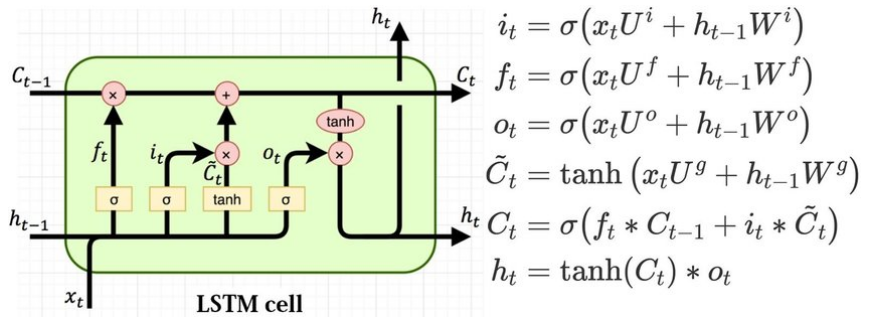

In [ ]:
count=0
embedding_mat=np.zeros((len(vocabulary)+1,300)) # tạo ma trận weight của từ dựa trên từ điển embed
for word,i in tqdm(word_index.items()):
    try:
        vec=model_embed[word]
        embedding_mat[i]=vec
    except KeyError:
        count+=1
        continue

print("Number of Out of Vocabulary",count)

In [ ]:
f1 = tfa.metrics.F1Score(num_classes=1, threshold=0.5)
accuracy = tf.keras.metrics.BinaryAccuracy(
    name='binary_accuracy', dtype=None, threshold=0.5
)

In [ ]:
inp = Input(shape=(max_len,))
x = Embedding(len(vocabulary)+1, feat_vec, weights=[embedding_mat], input_length=max_len,trainable=False)(inp) # trọng số của từ sẽ không được train lại
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Conv1D(64,3,activation="relu")(x)
x = GlobalMaxPool1D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)


print(model.summary())

nếu chạy nhiều epoch mà để learning rate cố định thì loss sẽ khó hội tụ, do đó cần định nghĩa hàm Reduce Learning rate và Early stopping. Có thể hiểu đơn giản kỹ thuật Early stopping được dùng để tránh overfit khi chúng ta train nhiều epoch nhưng val_loss hoặc val_acc không còn được cải thiện nữa. Kỹ thuật Reduce Learning sẽ giảm tốc độ learning rate đi khi train epoch mà độ lỗi trên tập validation không giảm nhiều.

In [ ]:
### defining some callbacks
opt=Adam(learning_rate=0.001)
bin_loss=tf.keras.losses.BinaryCrossentropy(
                                            from_logits=False, 
                                            label_smoothing=0,
                                            name='binary_crossentropy'
                                        )

## defining the call backs
early_stopping=tf.keras.callbacks.EarlyStopping(
                                                monitor="val_loss",
                                                patience=5,
                                                verbose=1,
                                                mode="min",
                                                restore_best_weights=True
                                              )
### Now reducing the learning rate when the model is not improvinig 
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(
                                                monitor="val_loss",
                                                factor=0.01,
                                                patience=2,
                                                verbose=1,
                                                mode="auto"
                                            )

my_callbacks=[early_stopping,reduce_lr]

# **4. Chạy model**

In [ ]:
model.compile(loss=bin_loss, optimizer=opt, metrics=[f1, accuracy])

history = model.fit(padded_doc, train.target, batch_size=512, epochs=25, validation_data=(val_padded_doc, val.target), callbacks = my_callbacks)

In [ ]:
fix, ax = plt.subplots(figsize=(20, 6))
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(ax=ax, title='Model Loss Curve')

In [ ]:
# model.compile(loss=bin_loss, optimizer=Adam(learning_rate=0.0015), metrics=[f1, accuracy])

# history = model.fit(padded_doc, train.target, batch_size=512, epochs=25, validation_data=(val_padded_doc, val.target), callbacks = my_callbacks)

In [ ]:
# fix, ax = plt.subplots(figsize=(20, 6))
# pd.DataFrame(history.history)[['loss', 'val_loss']].plot(ax=ax, title='Model Loss Curve')

In [ ]:
# !mkdir -p saved_model
# model.save('saved_model/model_v4') 

kết quả có vẻ tốt hơn so với trước khi preprocess

In [ ]:
y_pre=model.predict(val_padded_doc)

In [ ]:
thresh=0.36

for thresh in np.arange(0.1,0.5,0.01):
    print("threshold {0:2.2f} f1 score:{1:2.3f}".format(thresh,metrics.f1_score(val.target,(y_pre>thresh).astype(int))))

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(val.target, (y_pre>thresh).astype(int)))

# **5. Submit**

In [ ]:
y_test_pre=model.predict(test_padded_doc)
y_test_pre=(y_test_pre>thresh).astype(int)

## Creating the submission File
submit=pd.DataFrame()
submit["qid"]=test_data.qid
submit["prediction"]=y_test_pre
submit.to_csv("submission.csv",index=False)